In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/arimitramaiti/datasets/master/Classification/heart.csv"
dataset = pd.read_csv(url, error_bad_lines=False, header=0, index_col=None)
dataset.head()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


 - __Replicate Feature Selection methods and create train and test sets for each method separately__

In [3]:
sex_dummy = pd.get_dummies(dataset.sex)
sex_dummy.columns = ["Male", "Female"]

cp_dummy = pd.get_dummies(dataset.cp)
cp_dummy.columns = ["cp0", "cp1", "cp2", "cp3"]

fbs_dummy = pd.get_dummies(dataset.fbs)
fbs_dummy.columns = ["fbs0", "fbs1"]

restecg_dummy = pd.get_dummies(dataset.restecg)
restecg_dummy.columns = ["restecg0", "restecg1", "restecg2"]

exang_dummy = pd.get_dummies(dataset.exang)
exang_dummy.columns = ["exang0", "exang1"]

slope_dummy = pd.get_dummies(dataset.slope)
slope_dummy.columns = ["slope0", "slope1", "slope2"]

ca_dummy = pd.get_dummies(dataset.ca)
ca_dummy.columns = ["ca0", "ca1", "ca2", "ca3", "ca4"]

thal_dummy = pd.get_dummies(dataset.thal)
thal_dummy.columns = ["thal0", "thal1", "thal2", "thal3"]

tmp = dataset[["target", "age", "trestbps", "chol", "thalach", "oldpeak"]]

onehot_data = pd.concat([tmp, sex_dummy, cp_dummy, fbs_dummy, restecg_dummy, exang_dummy, slope_dummy, ca_dummy, thal_dummy],
                       axis=1)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectPercentile, chi2, f_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [5]:
X = onehot_data.drop('target', axis=1)
y = onehot_data['target']
X.shape, y.shape

((303, 30), (303,))

In [6]:
from sklearn.preprocessing import RobustScaler

 - __Perform scaling unlike Decision Tree Classifier which do not require scaling__
 - __Following scaling before train test split and feature extraction process__

In [7]:
vars_to_scale = X[["age", "trestbps", "chol", "thalach", "oldpeak"]]
scaler = RobustScaler()
vars_scaled = scaler.fit_transform(vars_to_scale)

vars_scaled = pd.DataFrame(vars_scaled, columns=["age", "trestbps", "chol", "thalach", "oldpeak"])
vars_original = X[X.columns.difference(vars_to_scale.columns)]

X_new = pd.concat([vars_original, vars_scaled], axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=0, stratify=y)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(242, 30) (61, 30) (242,) (61,)


# Feature Extraction : Mutual Information

In [20]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi, index=X_train.columns)
mi.sort_values(ascending=False, inplace=True)

sel = SelectKBest(mutual_info_classif, 10).fit(X_train, y_train)

train_copy = X_train
test_copy = X_test
train_copy.columns[sel.get_support()]
test_copy.columns[sel.get_support()]

X_train_mi = sel.transform(train_copy)
X_test_mi = sel.transform(test_copy)

del train_copy, test_copy
X_train_mi.shape, X_test_mi.shape

((242, 10), (61, 10))

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Find KNN best parameter for X_train (without any FE method)

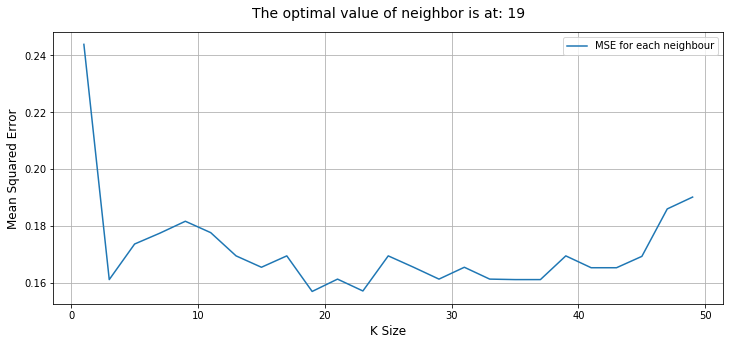

In [10]:
neighbors = list(range(1, 50, 2))
cv_score = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(estimator=knn, X=X_train, y=y_train, cv=StratifiedKFold(10), scoring="accuracy")
    cv_score.append(scores.mean())

MSE = [1- x for x in cv_score]

optimal_k = neighbors[MSE.index(min(MSE))]

fig = plt.figure(figsize=(12,5))
plt.plot(neighbors, MSE, label = 'MSE for each neighbour')
plt.ylabel('Mean Squared Error', fontsize = 12)
plt.xlabel('K Size', fontsize = 12)
plt.title('The optimal value of neighbor is at: ' + str(optimal_k), fontsize = 14, y = 1.03)
plt.legend()
plt.grid()
plt.show()

The accuracy score for the model is: 0.836
The recall score for the model is: 0.879


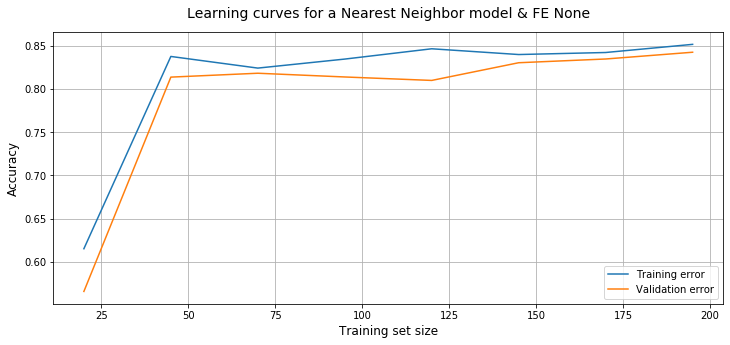

Text(91.68, 0.5, 'Actual')

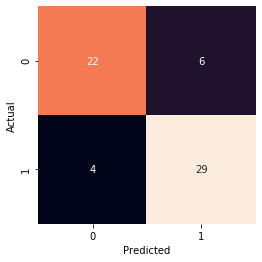

In [11]:
train_size = np.arange(optimal_k+1, (X_train.shape[0] - X_train.shape[1]) + 1, 25)
    
model = KNeighborsClassifier(n_neighbors=optimal_k)
train_sizes, train_scores, validation_scores = learning_curve(estimator = model,
                                                                  X = X_train,
                                                                  y = y_train,
                                                                  train_sizes = train_size,
                                                                  cv = StratifiedKFold(10),
                                                                  scoring = 'accuracy',
                                                                  shuffle = True,
                                                                  random_state=1)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
    
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = round(accuracy_score(y_test, y_pred),3)
rec = round(recall_score(y_test, y_pred),3)
    
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
    
fig = plt.figure(figsize=(12,5))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Accuracy', fontsize = 12)
plt.xlabel('Training set size', fontsize = 12)
plt.title('Learning curves for a Nearest Neighbor model & FE None', fontsize = 14, y = 1.03)
plt.legend()
plt.grid()
plt.show()

met = confusion_matrix(y_test, y_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Find SVC best parameter for X_train (without any FE method)

In [12]:
def svc_parameter(X_data, y_data):
    C_val = [0.001, 0.01, 0.1, 1, 10]
    gamma_val = [0.001, 0.01, 0.1, 1]
    kernel_val = ["linear", "rbf", "poly", "sigmoid"]
    degree_val = [0, 1, 2, 3, 4, 5, 6]
    param_grid = {'C': C_val, 'gamma': gamma_val, 'kernel': kernel_val, 'degree': degree_val}
    
    gs = GridSearchCV(SVC(), param_grid, cv=StratifiedKFold(10))
    gs.fit(X_data, y_data)
    gs.best_params_
    return gs.best_params_

In [13]:
best_param_values = svc_parameter(X_train, y_train)

The accuracy score for the model is: 0.885
The recall score for the model is: 0.939
The C value for the model is: 10
The kernel value for the model is: rbf
The degree value for the model is: 0
The gamma value for the model is: 0.001


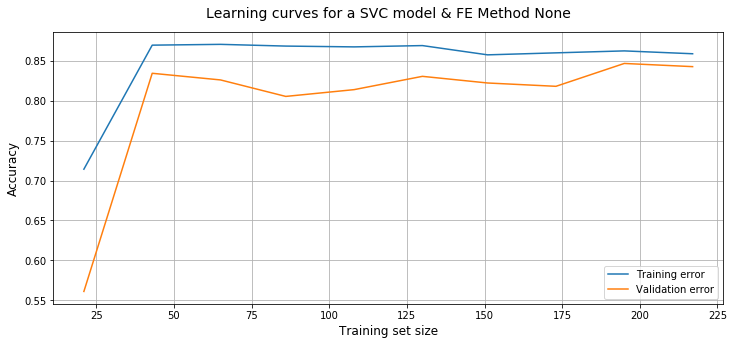

Text(91.68, 0.5, 'Actual')

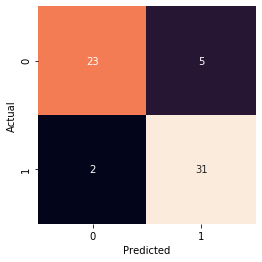

In [14]:
train_size = np.linspace(0.1, 1, 10)
    
model = SVC(C=best_param_values['C'],
            kernel=best_param_values['kernel'],
            degree=best_param_values['degree'],
            gamma=best_param_values['gamma'])
    
train_sizes, train_scores, validation_scores = learning_curve(estimator = model,
                                                                X = X_train,
                                                                y = y_train,
                                                                train_sizes = train_size,
                                                                cv = StratifiedKFold(10),
                                                                scoring = 'accuracy',
                                                                shuffle = True,
                                                                random_state=1)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
    
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = round(accuracy_score(y_test, y_pred),3)
rec = round(recall_score(y_test, y_pred),3)
   
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
print("The C value for the model is: {}".format(best_param_values['C']))
print("The kernel value for the model is: {}".format(best_param_values['kernel']))
print("The degree value for the model is: {}".format(best_param_values['degree']))
print("The gamma value for the model is: {}".format(best_param_values['gamma']))


fig = plt.figure(figsize=(12,5))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Accuracy', fontsize = 12)
plt.xlabel('Training set size', fontsize = 12)
plt.title('Learning curves for a SVC model & FE Method None', fontsize = 14, y = 1.03)
plt.legend()
plt.grid()
plt.show()

met = confusion_matrix(y_test, y_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [16]:
from sklearn.ensemble import VotingClassifier

# Hard Voting Classifier comparing KNN & SVC on X_train (w/o any FE method)

The accuracy score for the model is: 0.885
The recall score for the model is: 0.939


Text(91.68, 0.5, 'Actual')

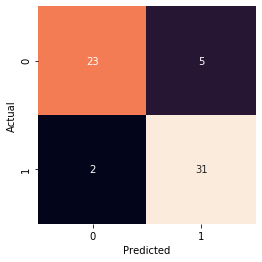

In [17]:
model1 = KNeighborsClassifier(n_neighbors=optimal_k)
model2 = SVC(C=best_param_values['C'],
            kernel=best_param_values['kernel'],
            degree=best_param_values['degree'],
            gamma=best_param_values['gamma'])

voting_hard = VotingClassifier(estimators=[
    ('knn', model1), ('svc', model2)],
    voting='hard',
    weights=[1,2])

voting_hard.fit(X_train, y_train)
voting_hard_pred = voting_hard.predict(X_test)
acc = round(accuracy_score(y_test, voting_hard_pred),3)
rec = round(recall_score(y_test, voting_hard_pred), 3)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
met = confusion_matrix(y_test, voting_hard_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Soft Voting Classifier comparing KNN & SVC on X_train (w/o any FE method)

The accuracy score for the model is: 0.852
The recall score for the model is: 0.879


Text(91.68, 0.5, 'Actual')

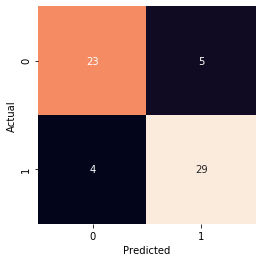

In [18]:
model1 = KNeighborsClassifier(n_neighbors=optimal_k)
model2 = SVC(C=best_param_values['C'],
            kernel=best_param_values['kernel'],
            degree=best_param_values['degree'],
            gamma=best_param_values['gamma'],
            probability = True)

voting_soft = VotingClassifier(estimators=[
    ('knn', model1), ('svc', model2)],
    voting='soft',
    weights=[1,2])

voting_soft.fit(X_train, y_train)
voting_soft_pred = voting_soft.predict(X_test)
acc = round(accuracy_score(y_test, voting_soft_pred),3)
rec = round(recall_score(y_test, voting_soft_pred), 3)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
met = confusion_matrix(y_test, voting_soft_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Find KNN best parameter for X_train (FE method-Mutual Info)

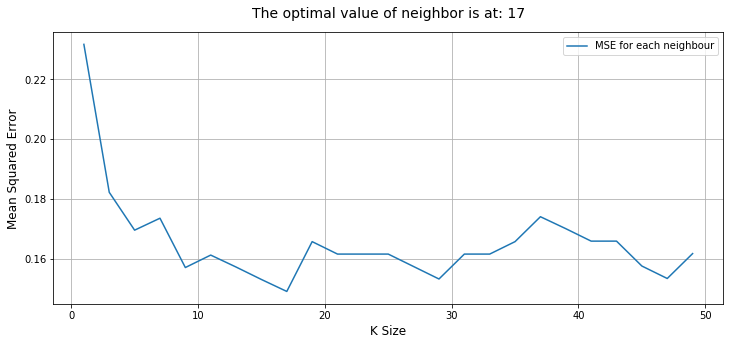

In [21]:
neighbors = list(range(1, 50, 2))
cv_score = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(estimator=knn, X=X_train_mi, y=y_train, cv=StratifiedKFold(10), scoring="accuracy")
    cv_score.append(scores.mean())

MSE = [1- x for x in cv_score]

optimal_k = neighbors[MSE.index(min(MSE))]

fig = plt.figure(figsize=(12,5))
plt.plot(neighbors, MSE, label = 'MSE for each neighbour')
plt.ylabel('Mean Squared Error', fontsize = 12)
plt.xlabel('K Size', fontsize = 12)
plt.title('The optimal value of neighbor is at: ' + str(optimal_k), fontsize = 14, y = 1.03)
plt.legend()
plt.grid()
plt.show()

The accuracy score for the model is: 0.82
The recall score for the model is: 0.848


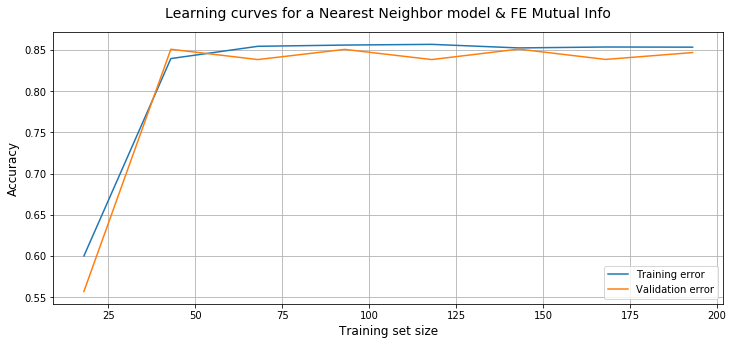

Text(91.68, 0.5, 'Actual')

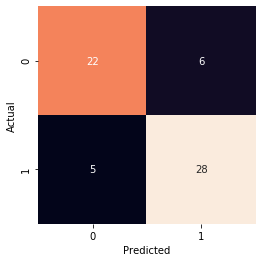

In [34]:
train_size = np.arange(optimal_k+1, 217, 25)
    
model = KNeighborsClassifier(n_neighbors=optimal_k)
train_sizes, train_scores, validation_scores = learning_curve(estimator = model,
                                                                  X = X_train_mi,
                                                                  y = y_train,
                                                                  train_sizes = train_size,
                                                                  cv = StratifiedKFold(10),
                                                                  scoring = 'accuracy',
                                                                  shuffle = True,
                                                                  random_state=1)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
    
model.fit(X_train_mi, y_train)
y_pred = model.predict(X_test_mi)
acc = round(accuracy_score(y_test, y_pred),3)
rec = round(recall_score(y_test, y_pred),3)
    
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
    
fig = plt.figure(figsize=(12,5))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Accuracy', fontsize = 12)
plt.xlabel('Training set size', fontsize = 12)
plt.title('Learning curves for a Nearest Neighbor model & FE Mutual Info', fontsize = 14, y = 1.03)
plt.legend()
plt.grid()
plt.show()

met = confusion_matrix(y_test, y_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Find SVC best parameter for X_train (FE method-Mutual Info)

In [31]:
best_param_values = svc_parameter(X_train_mi, y_train)

The accuracy score for the model is: 0.836
The recall score for the model is: 0.848
The C value for the model is: 1
The kernel value for the model is: rbf
The degree value for the model is: 0
The gamma value for the model is: 0.1


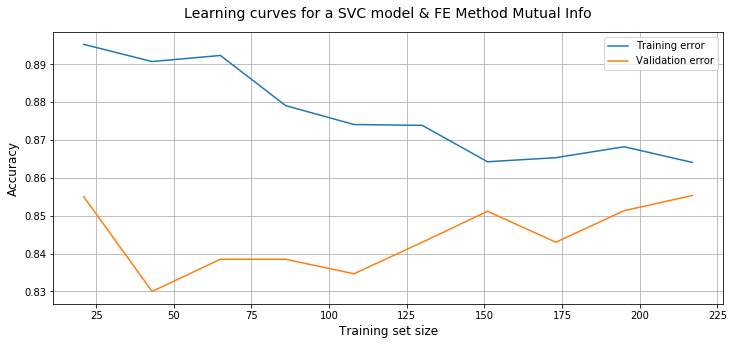

Text(91.68, 0.5, 'Actual')

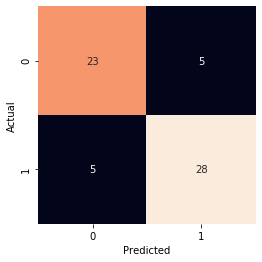

In [33]:
train_size = np.linspace(0.1, 1, 10)
    
model = SVC(C=best_param_values['C'],
            kernel=best_param_values['kernel'],
            degree=best_param_values['degree'],
            gamma=best_param_values['gamma'])
    
train_sizes, train_scores, validation_scores = learning_curve(estimator = model,
                                                                X = X_train_mi,
                                                                y = y_train,
                                                                train_sizes = train_size,
                                                                cv = StratifiedKFold(10),
                                                                scoring = 'accuracy',
                                                                shuffle = True,
                                                                random_state=1)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
    
model.fit(X_train_mi, y_train)
y_pred = model.predict(X_test_mi)
acc = round(accuracy_score(y_test, y_pred),3)
rec = round(recall_score(y_test, y_pred),3)
   
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
print("The C value for the model is: {}".format(best_param_values['C']))
print("The kernel value for the model is: {}".format(best_param_values['kernel']))
print("The degree value for the model is: {}".format(best_param_values['degree']))
print("The gamma value for the model is: {}".format(best_param_values['gamma']))


fig = plt.figure(figsize=(12,5))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Accuracy', fontsize = 12)
plt.xlabel('Training set size', fontsize = 12)
plt.title('Learning curves for a SVC model & FE Method Mutual Info', fontsize = 14, y = 1.03)
plt.legend()
plt.grid()
plt.show()

met = confusion_matrix(y_test, y_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Hard Voting Classifier comparing KNN & SVC on X_train (FE method-Mutual Info)

The accuracy score for the model is: 0.836
The recall score for the model is: 0.848


Text(91.68, 0.5, 'Actual')

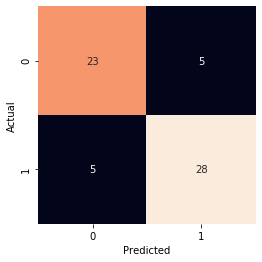

In [36]:
model1 = KNeighborsClassifier(n_neighbors=optimal_k)
model2 = SVC(C=best_param_values['C'],
            kernel=best_param_values['kernel'],
            degree=best_param_values['degree'],
            gamma=best_param_values['gamma'])

voting_hard = VotingClassifier(estimators=[
    ('knn', model1), ('svc', model2)],
    voting='hard',
    weights=[1,2])

voting_hard.fit(X_train_mi, y_train)
voting_hard_pred = voting_hard.predict(X_test_mi)
acc = round(accuracy_score(y_test, voting_hard_pred),3)
rec = round(recall_score(y_test, voting_hard_pred), 3)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
met = confusion_matrix(y_test, voting_hard_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Soft Voting Classifier comparing KNN & SVC on X_train (FE method-Mutual Info)

The accuracy score for the model is: 0.82
The recall score for the model is: 0.848


Text(91.68, 0.5, 'Actual')

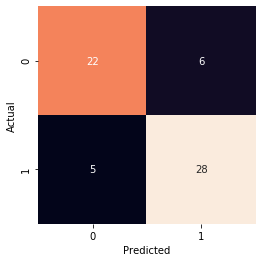

In [37]:
model1 = KNeighborsClassifier(n_neighbors=optimal_k)
model2 = SVC(C=best_param_values['C'],
            kernel=best_param_values['kernel'],
            degree=best_param_values['degree'],
            gamma=best_param_values['gamma'],
            probability = True)

voting_soft = VotingClassifier(estimators=[
    ('knn', model1), ('svc', model2)],
    voting='soft',
    weights=[1,2])

voting_soft.fit(X_train_mi, y_train)
voting_soft_pred = voting_soft.predict(X_test_mi)
acc = round(accuracy_score(y_test, voting_soft_pred),3)
rec = round(recall_score(y_test, voting_soft_pred), 3)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
met = confusion_matrix(y_test, voting_soft_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Feature Extraction : Anova Fischer

In [38]:
anova_f = f_classif(X_train, y_train)
p_values = pd.Series(anova_f[1], index=X_train.columns)
p_values.sort_values(ascending=False, inplace=True)

sel = SelectKBest(f_classif, 10).fit(X_train, y_train)

train_copy = X_train
test_copy = X_test
train_copy.columns[sel.get_support()]
test_copy.columns[sel.get_support()]

X_train_f = sel.transform(train_copy)
X_test_f = sel.transform(test_copy)

del train_copy, test_copy

X_train_f.shape, X_test_f.shape

((242, 10), (61, 10))

# Find KNN best parameter for X_train (FE method-Anova Fischer)

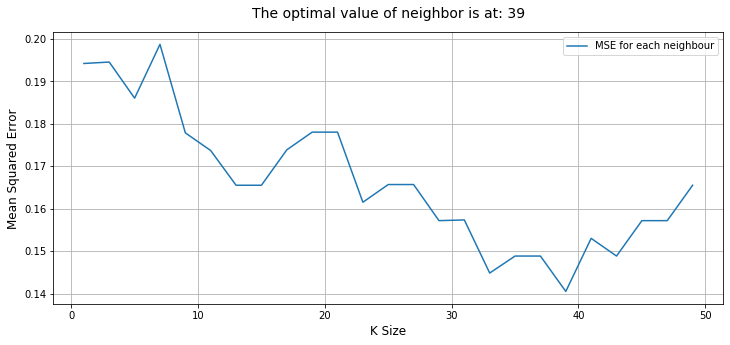

In [39]:
neighbors = list(range(1, 50, 2))
cv_score = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(estimator=knn, X=X_train_f, y=y_train, cv=StratifiedKFold(10), scoring="accuracy")
    cv_score.append(scores.mean())

MSE = [1- x for x in cv_score]

optimal_k = neighbors[MSE.index(min(MSE))]

fig = plt.figure(figsize=(12,5))
plt.plot(neighbors, MSE, label = 'MSE for each neighbour')
plt.ylabel('Mean Squared Error', fontsize = 12)
plt.xlabel('K Size', fontsize = 12)
plt.title('The optimal value of neighbor is at: ' + str(optimal_k), fontsize = 14, y = 1.03)
plt.legend()
plt.grid()
plt.show()

The accuracy score for the model is: 0.803
The recall score for the model is: 0.879


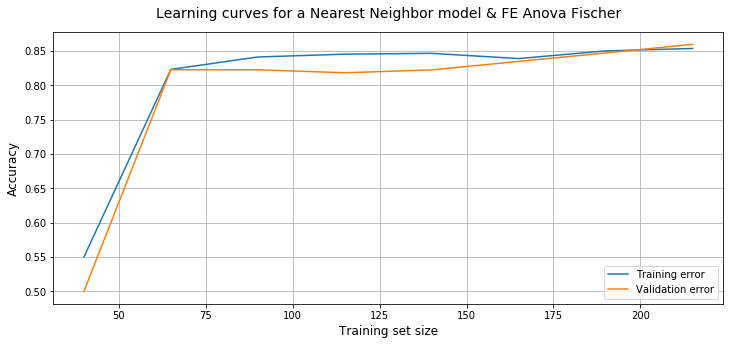

Text(91.68, 0.5, 'Actual')

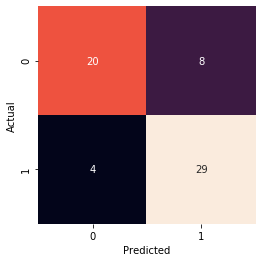

In [40]:
train_size = np.arange(optimal_k+1, (X_train_f.shape[0] - X_train_f.shape[1]) + 1, 25)
    
model = KNeighborsClassifier(n_neighbors=optimal_k)
train_sizes, train_scores, validation_scores = learning_curve(estimator = model,
                                                                  X = X_train_f,
                                                                  y = y_train,
                                                                  train_sizes = train_size,
                                                                  cv = StratifiedKFold(10),
                                                                  scoring = 'accuracy',
                                                                  shuffle = True,
                                                                  random_state=1)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
    
model.fit(X_train_f, y_train)
y_pred = model.predict(X_test_f)
acc = round(accuracy_score(y_test, y_pred),3)
rec = round(recall_score(y_test, y_pred),3)
    
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
    
fig = plt.figure(figsize=(12,5))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Accuracy', fontsize = 12)
plt.xlabel('Training set size', fontsize = 12)
plt.title('Learning curves for a Nearest Neighbor model & FE Anova Fischer', fontsize = 14, y = 1.03)
plt.legend()
plt.grid()
plt.show()

met = confusion_matrix(y_test, y_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Find SVC best parameter for X_train (FE method-Anova Fischer)

In [41]:
best_param_values = svc_parameter(X_train_f, y_train)

The accuracy score for the model is: 0.852
The recall score for the model is: 0.909
The C value for the model is: 1
The kernel value for the model is: rbf
The degree value for the model is: 0
The gamma value for the model is: 0.1


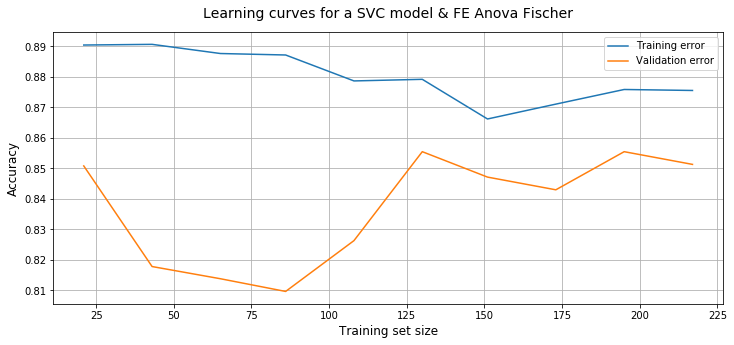

Text(91.68, 0.5, 'Actual')

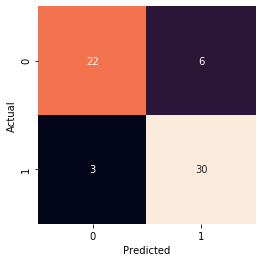

In [42]:
train_size = np.linspace(0.1, 1, 10)
    
model = SVC(C=best_param_values['C'],
            kernel=best_param_values['kernel'],
            degree=best_param_values['degree'],
            gamma=best_param_values['gamma'])
    
train_sizes, train_scores, validation_scores = learning_curve(estimator = model,
                                                                X = X_train_f,
                                                                y = y_train,
                                                                train_sizes = train_size,
                                                                cv = StratifiedKFold(10),
                                                                scoring = 'accuracy',
                                                                shuffle = True,
                                                                random_state=1)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
    
model.fit(X_train_f, y_train)
y_pred = model.predict(X_test_f)
acc = round(accuracy_score(y_test, y_pred),3)
rec = round(recall_score(y_test, y_pred),3)
   
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
print("The C value for the model is: {}".format(best_param_values['C']))
print("The kernel value for the model is: {}".format(best_param_values['kernel']))
print("The degree value for the model is: {}".format(best_param_values['degree']))
print("The gamma value for the model is: {}".format(best_param_values['gamma']))


fig = plt.figure(figsize=(12,5))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Accuracy', fontsize = 12)
plt.xlabel('Training set size', fontsize = 12)
plt.title('Learning curves for a SVC model & FE Anova Fischer', fontsize = 14, y = 1.03)
plt.legend()
plt.grid()
plt.show()

met = confusion_matrix(y_test, y_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Hard Voting Classifier comparing KNN & SVC on X_train (FE method-Anova Fischer)

The accuracy score for the model is: 0.852
The recall score for the model is: 0.909


Text(91.68, 0.5, 'Actual')

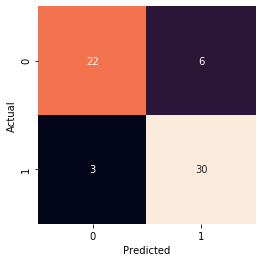

In [44]:
model1 = KNeighborsClassifier(n_neighbors=optimal_k)
model2 = SVC(C=best_param_values['C'],
            kernel=best_param_values['kernel'],
            degree=best_param_values['degree'],
            gamma=best_param_values['gamma'])

voting_hard = VotingClassifier(estimators=[
    ('knn', model1), ('svc', model2)],
    voting='hard',
    weights=[1,4])

voting_hard.fit(X_train_f, y_train)
voting_hard_pred = voting_hard.predict(X_test_f)
acc = round(accuracy_score(y_test, voting_hard_pred),3)
rec = round(recall_score(y_test, voting_hard_pred), 3)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
met = confusion_matrix(y_test, voting_hard_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Soft Voting Classifier comparing KNN & SVC on X_train (FE method-Anova Fischer)

The accuracy score for the model is: 0.852
The recall score for the model is: 0.909


Text(91.68, 0.5, 'Actual')

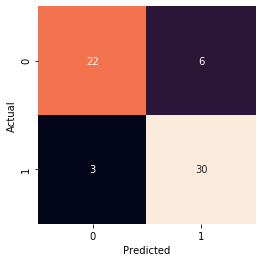

In [45]:
model1 = KNeighborsClassifier(n_neighbors=optimal_k)
model2 = SVC(C=best_param_values['C'],
            kernel=best_param_values['kernel'],
            degree=best_param_values['degree'],
            gamma=best_param_values['gamma'],
            probability = True)

voting_soft = VotingClassifier(estimators=[
    ('knn', model1), ('svc', model2)],
    voting='soft',
    weights=[1,4])

voting_soft.fit(X_train_f, y_train)
voting_soft_pred = voting_soft.predict(X_test_f)
acc = round(accuracy_score(y_test, voting_soft_pred),3)
rec = round(recall_score(y_test, voting_soft_pred), 3)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
met = confusion_matrix(y_test, voting_soft_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Feature Extraction : RFECV

In [46]:
del X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

rfe = RFECV(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), 
          step=1, 
          cv=StratifiedKFold(10),
          scoring='accuracy', 
          n_jobs=-1).fit(X_train, y_train)

train_copy = X_train
test_copy = X_test

train_copy.drop(train_copy.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)
test_copy.drop(test_copy.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)

X_train_rfe = pd.DataFrame(train_copy)
X_test_rfe = pd.DataFrame(test_copy)
X_train_rfe.shape, X_test_rfe.shape

((242, 26), (61, 26))

# Find KNN best parameter for X_train (FE method-RFECV)

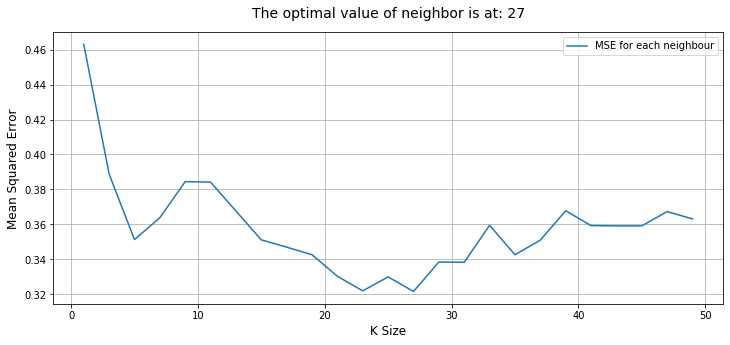

In [47]:
neighbors = list(range(1, 50, 2))
cv_score = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(estimator=knn, X=X_train_rfe, y=y_train, cv=StratifiedKFold(10), scoring="accuracy")
    cv_score.append(scores.mean())

MSE = [1- x for x in cv_score]

optimal_k = neighbors[MSE.index(min(MSE))]

fig = plt.figure(figsize=(12,5))
plt.plot(neighbors, MSE, label = 'MSE for each neighbour')
plt.ylabel('Mean Squared Error', fontsize = 12)
plt.xlabel('K Size', fontsize = 12)
plt.title('The optimal value of neighbor is at: ' + str(optimal_k), fontsize = 14, y = 1.03)
plt.legend()
plt.grid()
plt.show()

The accuracy score for the model is: 0.77
The recall score for the model is: 0.848


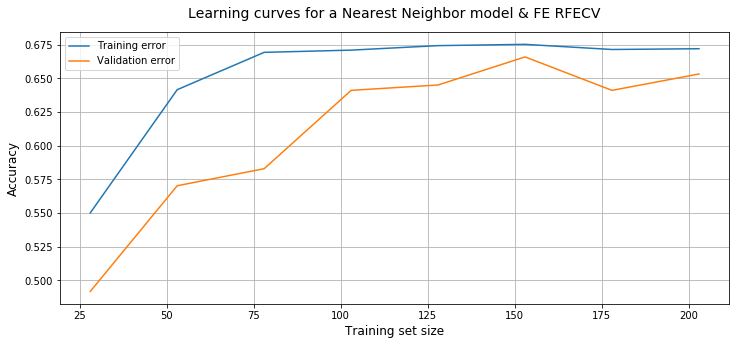

Text(91.68, 0.5, 'Actual')

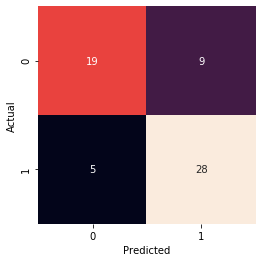

In [49]:
train_size = np.arange(optimal_k+1, (X_train_rfe.shape[0] - X_test_rfe.shape[1]) + 1, 25)
    
model = KNeighborsClassifier(n_neighbors=optimal_k)
train_sizes, train_scores, validation_scores = learning_curve(estimator = model,
                                                                  X = X_train_rfe,
                                                                  y = y_train,
                                                                  train_sizes = train_size,
                                                                  cv = StratifiedKFold(10),
                                                                  scoring = 'accuracy',
                                                                  shuffle = True,
                                                                  random_state=1)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
    
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)
acc = round(accuracy_score(y_test, y_pred),3)
rec = round(recall_score(y_test, y_pred),3)
    
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
    
fig = plt.figure(figsize=(12,5))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Accuracy', fontsize = 12)
plt.xlabel('Training set size', fontsize = 12)
plt.title('Learning curves for a Nearest Neighbor model & FE RFECV', fontsize = 14, y = 1.03)
plt.legend()
plt.grid()
plt.show()

met = confusion_matrix(y_test, y_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Find SVC best parameter for X_train (FE RFECV)

In [56]:
def svc_parameter(X_data, y_data):
    C_val = [0.001, 0.01, 0.1, 1, 10]
    gamma_val = [0.001, 0.01, 0.1, 1]
    kernel_val = ["rbf"]
    degree_val = [0, 1, 2, 3, 4, 5, 6]
    param_grid = {'C': C_val, 'gamma': gamma_val, 'kernel': kernel_val, 'degree': degree_val}
    
    gs = GridSearchCV(SVC(), param_grid, cv=StratifiedKFold(10))
    gs.fit(X_data, y_data)
    gs.best_params_
    return gs.best_params_

In [57]:
best_param_values = svc_parameter(X_train_rfe, y_train)

The accuracy score for the model is: 0.754
The recall score for the model is: 0.788
The C value for the model is: 1
The kernel value for the model is: rbf
The degree value for the model is: 0
The gamma value for the model is: 0.001


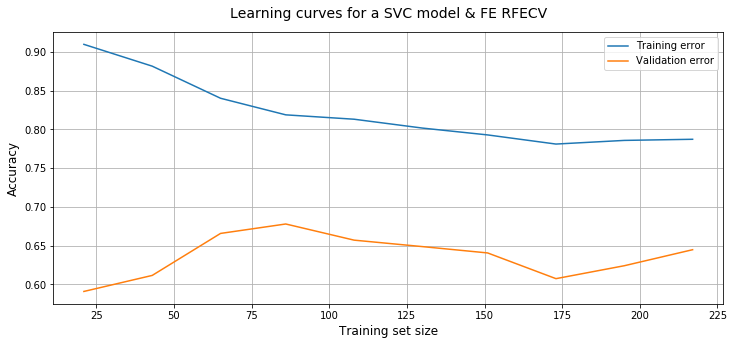

Text(91.68, 0.5, 'Actual')

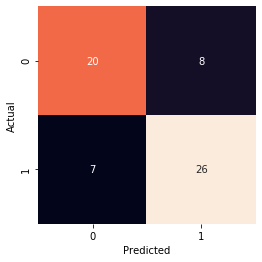

In [58]:
train_size = np.linspace(0.1, 1, 10)
    
model = SVC(C=best_param_values['C'],
            kernel=best_param_values['kernel'],
            degree=best_param_values['degree'],
            gamma=best_param_values['gamma'])
    
train_sizes, train_scores, validation_scores = learning_curve(estimator = model,
                                                                X = X_train_rfe,
                                                                y = y_train,
                                                                train_sizes = train_size,
                                                                cv = StratifiedKFold(10),
                                                                scoring = 'accuracy',
                                                                shuffle = True,
                                                                random_state=1)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
    
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)
acc = round(accuracy_score(y_test, y_pred),3)
rec = round(recall_score(y_test, y_pred),3)
   
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
print("The C value for the model is: {}".format(best_param_values['C']))
print("The kernel value for the model is: {}".format(best_param_values['kernel']))
print("The degree value for the model is: {}".format(best_param_values['degree']))
print("The gamma value for the model is: {}".format(best_param_values['gamma']))


fig = plt.figure(figsize=(12,5))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Accuracy', fontsize = 12)
plt.xlabel('Training set size', fontsize = 12)
plt.title('Learning curves for a SVC model & FE RFECV', fontsize = 14, y = 1.03)
plt.legend()
plt.grid()
plt.show()

met = confusion_matrix(y_test, y_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Hard Voting Classifier comparing KNN & SVC on X_train (FE method-RFECV)

The accuracy score for the model is: 0.77
The recall score for the model is: 0.848


Text(91.68, 0.5, 'Actual')

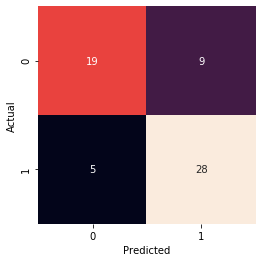

In [62]:
model1 = KNeighborsClassifier(n_neighbors=optimal_k)
model2 = SVC(C=best_param_values['C'],
            kernel=best_param_values['kernel'],
            degree=best_param_values['degree'],
            gamma=best_param_values['gamma'])

voting_hard = VotingClassifier(estimators=[
    ('knn', model1), ('svc', model2)],
    voting='hard',
    weights=[3,1])

voting_hard.fit(X_train_rfe, y_train)
voting_hard_pred = voting_hard.predict(X_test_rfe)
acc = round(accuracy_score(y_test, voting_hard_pred),3)
rec = round(recall_score(y_test, voting_hard_pred), 3)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
met = confusion_matrix(y_test, voting_hard_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Soft Voting Classifier comparing KNN & SVC on X_train (FE method-RFECV)

The accuracy score for the model is: 0.738
The recall score for the model is: 0.788


Text(91.68, 0.5, 'Actual')

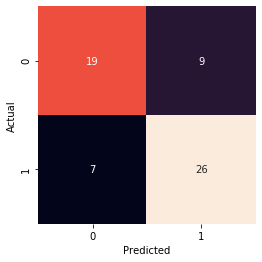

In [63]:
model1 = KNeighborsClassifier(n_neighbors=optimal_k)
model2 = SVC(C=best_param_values['C'],
            kernel=best_param_values['kernel'],
            degree=best_param_values['degree'],
            gamma=best_param_values['gamma'],
            probability = True)

voting_soft = VotingClassifier(estimators=[
    ('knn', model1), ('svc', model2)],
    voting='soft',
    weights=[3,1])

voting_soft.fit(X_train_rfe, y_train)
voting_soft_pred = voting_soft.predict(X_test_rfe)
acc = round(accuracy_score(y_test, voting_soft_pred),3)
rec = round(recall_score(y_test, voting_soft_pred), 3)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
met = confusion_matrix(y_test, voting_soft_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")